Question:
How does increased life expectancy impact population and age demographics?

In [49]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [50]:
from pandas import read_csv
filename = 'project1data.csv'
tables = read_csv(filename, header=0, index_col=0, decimal='M')

,UN,life_expectancy1,_expectancyx1000,birthrate10000,fer_rate,fer_ratex1000
1965,3329122479,53,53261,334,5.025,5025
1966,3397475247,54,54100,334,4.996,4996
1967,3468521724,55,54919,334,4.951,4951
1968,3541674891,56,55680,334,4.891,4891
1969,3616108749,56,56364,334,4.818,4818
1970,3691172616,57,56964,308,4.731,4731
1971,3766754345,57,57490,308,4.63,4630
1972,3842873611,58,57969,308,4.517,4517
1973,3919182332,58,58425,308,4.397,4397
1974,3995304922,59,58865,308,4.273,4273


In [51]:
def plot_results( un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [52]:
life_expectancy = tables._expectancyx1000/1000
birth_rate = tables.birthrate10000/10000
fer_rate = tables.fer_ratex1000/1000;


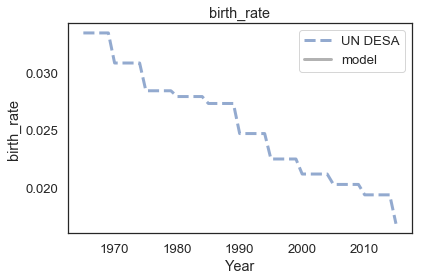

In [53]:
def plot_results(birth_rate, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(birth_rate, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)
birth_rate = tables.birthrate10000/10000
empty = TimeSeries()
plot_results(birth_rate, empty, 'life expectancy')
    
decorate(xlabel='Year', 
             ylabel='birth_rate',
             title='birth_rate')

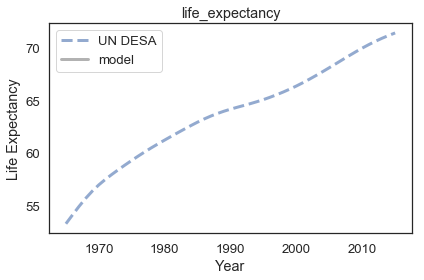

In [54]:
def plot_results( life_expectancy, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(life_expectancy, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)
life_expectancy= tables._expectancyx1000/1000
empty = TimeSeries()
plot_results(life_expectancy, empty, 'life expectancy')
    
decorate(xlabel='Year', 
             ylabel='Life Expectancy',
             title='life_expectancy')

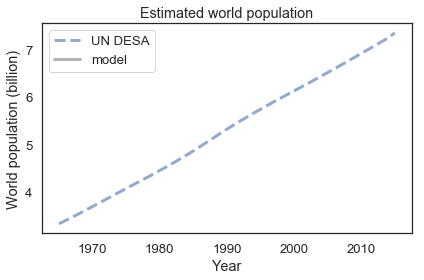

In [55]:
un = tables.UN / 1e9
empty = TimeSeries()
plot_results(un, empty, 'UN DESA')
    
decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title='Estimated world population')


In [64]:
young = get_first_value(un) * 0.47
old= get_first_value(un) * 0.2
middle = get_first_value(un)*0.33
init = State(young=young, middle=middle, old=old)

,values
young,1.564688
middle,1.098610
old,0.665824


In [65]:
death_rate = 1/((life_expectancy)-44)
birth_rate = fer_rate/(26*2);
#children per woman in her fer age per year

In [66]:
system = System(birth_rate2 = .08,
                mature_rate = 1/19,
                elder_rate = 1/26,
                t_0 = 1965,
                t_end = 2016,
                init=init)

,values
birth_rate2,0.08
mature_rate,0.0526316
elder_rate,0.0384615
t_0,1965
t_end,2016
init,young 1.564688 middle 1.098610 old ...


In [67]:
def update_func1(state, t, system):
    birth_rate2 = birth_rate[t]
    births = birth_rate2*state.middle
    #births = system.birth_rate2 * state.middle
    maturings = system.mature_rate * state.young
    agings = system.elder_rate * state.middle
    death_rate2 = death_rate[t]
    deaths = death_rate2 * state.old
    young = state.young + births - maturings
    middle = state.middle + maturings - agings
    old = state.old + agings - deaths
    
    return State(young=young, middle=middle, old=old)
    

In [68]:
state = update_func1(init, system.t_0, system)

,values
young,1.588499
middle,1.138708
old,0.636183


In [69]:
state = update_func1(state, system.t_0, system)

,values
young,1.614933
middle,1.178517
old,0.611285


In [70]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    init: initial State object
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    
    state = system.init
    results[system.t_0] = state.young + state.middle + state.old
    
    for t in linrange(system.t_0, system.t_end):
        state = update_func(state, t, system)
        results[t+1] = state.young + state.middle + state.old
        
    return results

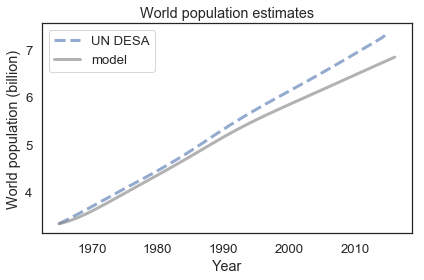

In [71]:
results = run_simulation(system, update_func1);
plot_results(un, results, 'World population estimates')

Interpretation:
It seems like this isn't a very good model. Looking at the first year, 20% of the population is 45 or over, and the life expectancy is 46, which means that theoretically 50% of those people over  44 should die in 1950, which makes very clear that something is wrong.